**Artificial Neural Networks for Clickbait Detection in ClickbaitTR**

---

In [3]:
!git clone -v https://github.com/ahmetax/kalbur.git 

Cloning into 'kalbur'...
POST git-upload-pack (165 bytes)
remote: Enumerating objects: 205, done.
remote: Total 205 (delta 0), reused 0 (delta 0), pack-reused 205
Receiving objects: 100% (205/205), 1.24 MiB | 2.59 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [0]:
import preprocessing as pr
import sys

pr.current_path = "/content/"

with open(pr.current_path + 'kalbur/kelime_bol.py', 'r') as file :
  filedata = file.read()

if "kalbur/veri/" not in filedata:
  filedata = filedata.replace('veri/', pr.current_path + "kalbur/veri/")

  with open(pr.current_path + 'kalbur/kelime_bol.py', 'w') as file:
    file.write(filedata)

sys.path.append(pr.current_path + "kalbur/")

In [21]:
csv_files = {"limon":"dataset/limon_clickbait.csv",
             "evrensel":"dataset/evrensel_non-clickbait.csv",
             "spoiler":"dataset/spoiler_clickbait.csv",
             "diken":"dataset/diken_non-clickbait.csv"}

clickbait, non_clickbait = pr.return_data(csv_files)

special_characters = ["#", "?", "!", ".", "@"]

words_will_be_removed = ["işçi", "eylem", "meteoroloji", "katliam", 
                          "murat", "altı", "seçim", "diren", "dev", 
                          "gazze", "blog", "protesto", "beş", 
                          "yaşam", "manşet", "günaydın", "türkiye", 
                          "sınır","chp", "grev", "yaralı", "ateşkes", 
                          "yazı", "maden", "bayi", "limonhaber", "diken", "hdp",
                          "limon", "emek", "evrensel", "spoiler",
                          "gtgtgt", "evrenselpazar"]

number_of_tweets = 1000 # for toy example
unique_word_list, word_indexes, Xsc, Y = pr.generatesample(clickbait[:number_of_tweets], non_clickbait[:number_of_tweets], 
                                                          special_characters, words_will_be_removed, 
                                                          isseparate=False, scaling=True, 
                                                          for_data_generator=True)

# of tweets in limon: 22133
# of tweets in evrensel: 13093
# of tweets in spoiler: 1898
# of tweets in diken: 10936


In [0]:
from keras.utils import Sequence
import numpy as np

class DataGenerator(Sequence):
  def __init__(self, unique_word_list, word_indexes, Xsc, Y, batch_size=128, shuffle=True):
    self.batch_size = batch_size
    self.unique_word_list = unique_word_list
    self.word_indexes = word_indexes
    self.Xsc = Xsc
    self.Y = Y
    self.shuffle = shuffle
    self.indexes = Xsc.shape[0]
    self.on_epoch_end()

  def __len__(self):
    return math.ceil(len(self.Xsc) / self.batch_size)

  def __getitem__(self, index):
    idxs = [i for i in range(index*self.batch_size,min((index+1)*self.batch_size, len(Xsc)))]
    coded_tweets = []
    for idx in idxs:
      coded_tweet = np.zeros((1, len(unique_word_list)))
      for indx in word_indexes[idx]:
        coded_tweet[:, indx] += 1
      coded_tweets.append(coded_tweet)
    coded_tweets = np.squeeze(np.array(coded_tweets))
    X_batch = np.c_[coded_tweets, Xsc[idxs]]
    Y_batch = Y[idxs]
    return X_batch, Y_batch

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.Y))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

In [28]:
batch_size = 128
sample_size = len(Xsc)

train_generator = DataGenerator(unique_word_list, word_indexes[sample_size//5:], Xsc[sample_size//5:], Y[sample_size//5:], batch_size=batch_size)
validation_generator = DataGenerator(unique_word_list, word_indexes[:sample_size//5], Xsc[:sample_size//5], Y[:sample_size//5], batch_size=batch_size)

print("# of unique words:", len(unique_word_list))

# of unique words: 2919


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2928)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                187456    
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 187,521
Trainable params: 187,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
13/13 [==============================] - 0s 19ms/step - loss: 0.4648 - accuracy: 0.7800 - val_loss: 0.1092 - val_accuracy: 0.9648
Epoch 2/32
13/13 [==============================] - 0s 14ms/step - loss: 0.1120 - accuracy: 0.9615 - val_loss: 0.0781 - val_accuracy: 0.9922
Epoch 3/32
13/13 [==============================] - 0s 12ms/step - loss: 0.0288 - accuracy: 0.9904 - 

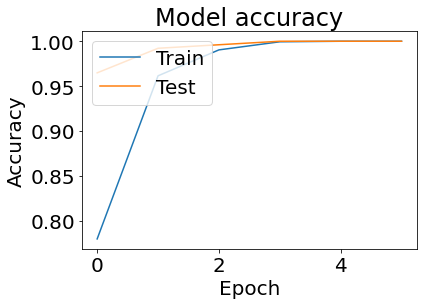

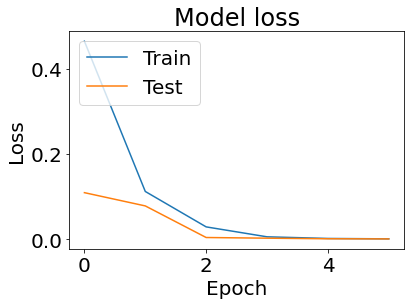

In [29]:
from keras.layers import Input, Dense, Embedding, LSTM, concatenate, CuDNNLSTM
from keras.models import Model
from keras.utils import plot_model
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import math

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
inp = Input(shape=(len(unique_word_list) + 9,), name='input')
h1 = Dense(64, activation="relu")(inp)
h2 = Dense(32, activation="relu")(h1)
output = Dense(1, activation='sigmoid', name='output')(h1)

model = Model(inputs=[inp], outputs=output)
adam = optimizers.Adam(lr=0.05)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

plot_model(model, to_file='model.png')

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=32, callbacks=[es])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
def featureimportance(weights, all_features):
    coefs = weights
    inputvalues = {}
    k = 0
    for i in coefs[0].numpy():
        inputvalue = 0
        for j in i:
            inputvalue = inputvalue + abs(j)
        inputvalues.update({all_features[k]: inputvalue})
        k = k + 1
    return inputvalues

def featureselection(inputvalues, N):
    inv = {}
    for key, val in inputvalues.items():
        inv[val] = inv.get(val, []) + [key]
    inputvalues = list(inputvalues.values())
    inputvalues.sort(reverse = True)
    inputvalues = inputvalues[:N]
    keys = []
    for j in inputvalues:
        keys.append(inv[j])
    return [k[0] for k in keys], inputvalues

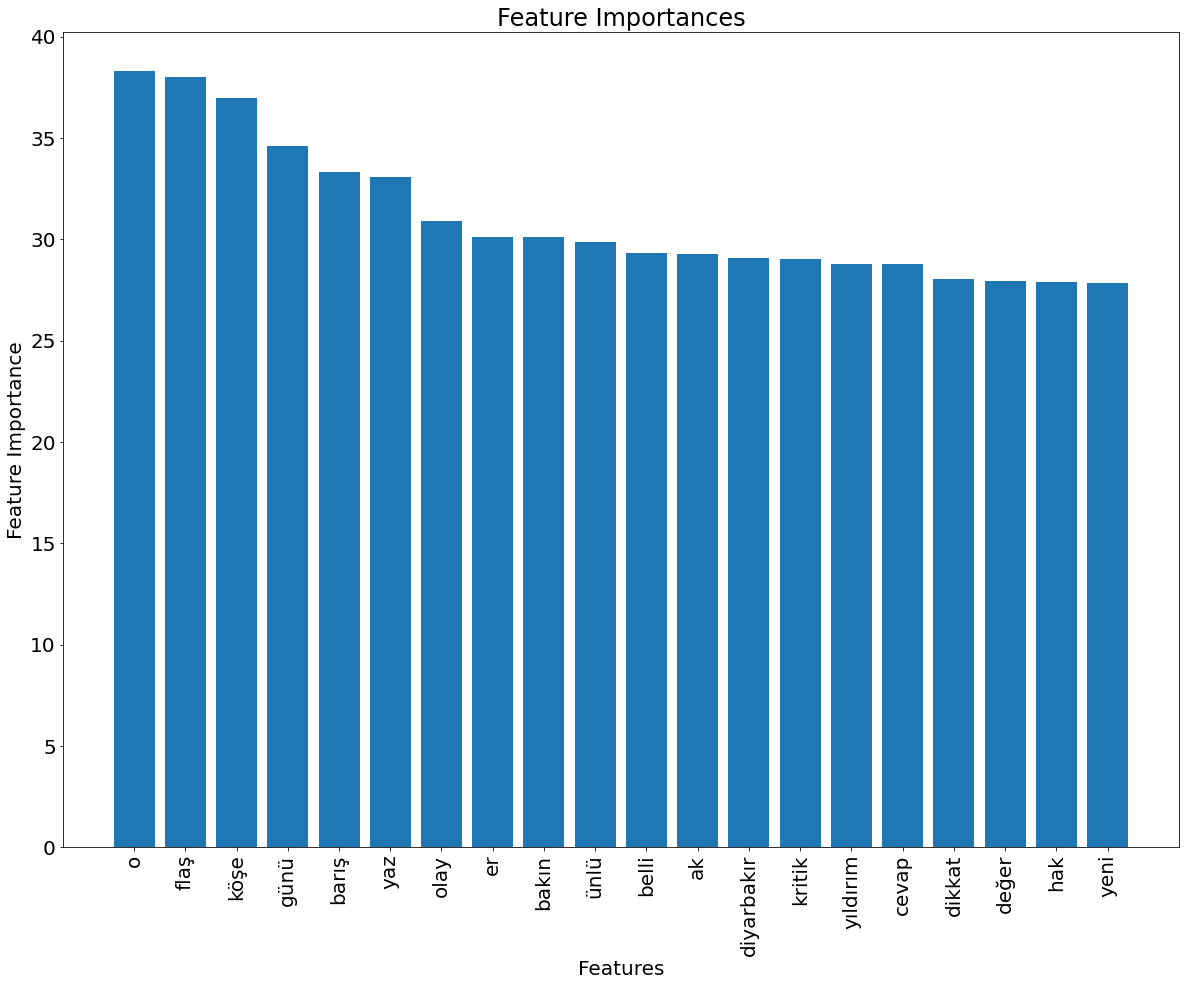

In [31]:
input_values = featureimportance(model.weights, unique_word_list + special_characters + ["o. special", "uppercases", "word length", "tweet length"])
keys, truncated_input_values = featureselection(input_values, 20)

plt.figure(figsize=(20, 15))
csfont = {'fontname':'Arial'}
plt.title("Feature Importances",**csfont)
plt.xlabel('Features', **csfont)
plt.ylabel('Feature Importance', **csfont)
plt.rcParams['font.size'] = 20
plt.xticks(rotation=90)
y_pos = np.arange(len(keys))
plt.bar(keys, truncated_input_values)
plt.xticks(y_pos, keys)
plt.show()
